In [1]:
import tensorflow as tf
import numpy as np
import random
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

载入Atari撞球游戏

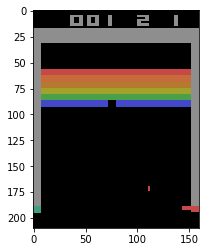

In [2]:
env = gym.make("Breakout-v0")
s = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for i in range(200):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    a = env.action_space.sample()
    s1, r, d, _ = env.step(a)
    if d==True:
        break

状态变量变为游戏图像，使用卷积神经网络建模，目标函数分解为对偶的状态优势和动作优势，使两者解耦，预测结果更鲁棒。

In [3]:
class QNetwork:
    def __init__(self, h_size):
        # shape: N,100800
        self.inputs = tf.placeholder(dtype=tf.float32, shape=[None, 210*160*3])
        # N,210,160,3
        imgs = tf.reshape(self.inputs, shape=[-1, 210, 160, 3])
        # N,x1,y1,32
        conv1 = tf.layers.conv2d(imgs, filters=32, kernel_size=8, strides=4, padding='VALID', bias_initializer=None)
        # N,x2,y2,64
        conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=4, strides=2, padding='VALID', bias_initializer=None)
        # N,x3,y3,128
        conv3 = tf.layers.conv2d(conv2, filters=128, kernel_size=2, strides=1, padding='VALID', bias_initializer=None)
        # N,x4,y4,512
        conv4 = tf.layers.conv2d(conv3, filters=h_size, kernel_size=1, strides=1, padding='VALID', bias_initializer=None)

        # N,x4,y4,256, N,x4,y4,256
        streamAC, streamVC = tf.split(conv4, 2, 3)
        # N,x4*y4*256
        streamA = tf.contrib.layers.flatten(streamAC)
        streamV = tf.contrib.layers.flatten(streamVC)
        # N,4(action_space.n)
        A = tf.layers.dense(streamA, env.action_space.n, use_bias=False)
        # N,1
        V = tf.layers.dense(streamV, 1, use_bias=False)

        # N,4
        self.Qout = V + tf.subtract(A, tf.reduce_mean(A, axis=1, keep_dims=True))
        # N,1
        self.predict = tf.argmax(self.Qout, axis=1)

        # N,1
        self.targetQ = tf.placeholder(dtype=tf.float32, shape=[None])
        # N,1
        self.actions = tf.placeholder(dtype=tf.int32, shape=[None])
        # N,4
        actions_onehot = tf.one_hot(self.actions, env.action_space.n, dtype=tf.float32)

        # N,1
        Q = tf.reduce_sum(tf.multiply(self.Qout, actions_onehot), axis=1)
        # 1
        loss = tf.square(tf.reduce_sum(Q - self.targetQ))
        optmize = tf.train.AdamOptimizer(learning_rate=0.001)
        self.update = optmize.minimize(loss)

训练过程，使用双向队列和随机采样实现"经验回放"，

In [5]:
from collections import deque
buff = deque(maxlen=5000)

h_size = 512
tf.reset_default_graph()
mainQN = QNetwork(h_size)
targetQN = QNetwork(h_size)

num_episode = 1000
num_exp = 1000
e = 0.8
total_step = 0
batch_size = 32
discount = 0.99

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episode):
        s = env.reset()
        s = np.reshape(s, -1)
        rAll = 0
        for j in range(num_exp):
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.inputs:[s]})[0]
            s1, r, d, _ = env.step(a)
            s1 = np.reshape(s1, -1)
            buff.append(np.array([s,a,r,s1,d]))
            s = s1
            rAll += r
            total_step += 1
            
            # update the Qnetwork
            if total_step % 50 == 0:
                batch = np.reshape(random.sample(buff, batch_size),[batch_size,5])
                acts = sess.run(mainQN.predict, feed_dict={mainQN.inputs:np.stack(batch[:,3])})
                QN = sess.run(targetQN.Qout, feed_dict={targetQN.inputs:np.stack(batch[:,3])})
                end_token = -(batch[:,4]-1) # 游戏结束，负向惩罚
                newQ = batch[:,2] + discount*QN[:,acts[0]]*end_token
                sess.run(mainQN.update, feed_dict={mainQN.inputs:np.stack(batch[:,0]), mainQN.targetQ:newQ,
                                                   mainQN.actions:batch[:,1]})
                if total_step % 500 == 0:
                    sess.run(targetQN.update, feed_dict={targetQN.inputs:np.stack(batch[:,0]), 
                                                         targetQN.targetQ:newQ, targetQN.actions:batch[:,1]})
                    # show the precedure
                    print i, rAll, e
                # reduce the random probability
                e = 1.0/((total_step/500)+1)
            
            if d==True:
                break

1 500 2.0 0.1
2 1000 2.0 0.05
5 1500 0.0 0.0333333333333
6 2000 1.0 0.025
7 2500 2.0 0.02
10 3000 0.0 0.0166666666667
12 3500 1.0 0.0142857142857
13 4000 2.0 0.0125
15 4500 0.0 0.0111111111111
18 5000 0.0 0.01
19 5000 0.0 0.00909090909091
19 5000 0.0 0.00833333333333
20 5000 0.0 0.00769230769231


KeyboardInterrupt: 